In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import scipy
import os

from scipy.stats import mannwhitneyu

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

plt.style.use("ggplot")
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["figure.titleweight"] = "bold"
plt.rcParams["figure.dpi"] = 300

img_path = "../img/"
data_path = "../data/"

## Load Data

In [2]:
g7_df = pd.read_csv(filepath_or_buffer=os.path.join(data_path, "g7_df.csv"),
                    index_col = ["Country", "Year"])
dev7_df = pd.read_csv(os.path.join(data_path, "dev7_df.csv"), 
                      index_col=["Country", "Year"])

From our Exploratory Data Analysis, we have visualized the distributions of all features for both G7 and Dev-7 Countries. We can use those as reference on how we will be dealing with the null values and the necessary pre-processing.

![feature distributions](../img/feature_distribs.png "Feature Distributions")

To reiterate, we can see that most features follow a **lognormal distribution** and there are some who follow a **bimodal distribution**. There are also **a lot of** features that contain **outliers**.

## Splitting the data

Before anything, **we have to split the data first, to ensure that there is no data leakage** from the test set. Given that this is primarily panel data, it is important that we do not shuffle, since each entity (in this case country), contains a timeseries of each feature. Hence, instead of utilizing the function provided by scikit learn, we create our custom function by splitting using the index.

In [3]:
# Split X and y per dataframe

g7_X = g7_df.iloc[:, 1:]
g7_y = g7_df.iloc[:, 0]

dev7_X = dev7_df.iloc[:, 1:]
dev7_y = dev7_df.iloc[:, 0]

In [4]:
# we will use 2011 - 2015 as the validation set
# and use 2016-2018 as the time frame for the test set

train_idx = (slice(None), np.arange(1990, 2011))
val_idx = (slice(None), np.arange(2011, 2016))
test_idx = (slice(None), np.arange(2016, 2019))

def panel_split(X, y, 
                train_idx=train_idx, 
                val_idx=val_idx,
                test_idx=test_idx):
    # sort index to retain multi-index
    X_train = (X.loc[train_idx, :]
                .sort_index(level=["Country", "Year"]))
    y_train = (y.loc[train_idx]
               .sort_index(level=["Country", "Year"]))
    
    X_val = (X.loc[val_idx, :]
                .sort_index(level=["Country", "Year"]))
    y_val = (y.loc[val_idx]
               .sort_index(level=["Country", "Year"]))
    
    X_test = (X.loc[test_idx, :]
                .sort_index(level=["Country", "Year"]))
    y_test = (y.loc[test_idx]
               .sort_index(level=["Country", "Year"]))
    
    return (X_train, X_val, X_test,
            y_train, y_val, y_test)

# split
(g7_X_train, g7_X_val, g7_X_test, 
 g7_y_train, g7_y_val, g7_y_test) = panel_split(g7_X, g7_y)
(dev7_X_train, dev7_X_val, dev7_X_test, 
 dev7_y_train, dev7_y_val, dev7_y_test) = panel_split(dev7_X, dev7_y)

In [5]:
# Show NaN percentage per column
def diag_nan_category(dataframes, titles=["Train", "Validation", "Test"]):
    def diag_nan_col(data, title):
        print(title, ":")
        display(data.isnull().sum()/data.shape[0])
    [diag_nan_col(df, title) for df, title in zip(dataframes, titles)]

# G7
g7_datasets = [g7_X_train, g7_X_val, g7_X_test]
diag_nan_category(g7_datasets)

Train :


ghg_pergdp               0.000000
gdp_percapita            0.047619
population               0.000000
fossilfuels_percapita    0.000000
nuclear_percapita        0.000000
renewables_percapita     0.000000
yearly_oil_co2           0.000000
yearly_gas_co2           0.000000
yearly_flaring_co2       0.000000
yearly_coal_co2          0.000000
yearly_cement_co2        0.000000
dtype: float64

Validation :


ghg_pergdp               0.0
gdp_percapita            0.0
population               0.0
fossilfuels_percapita    0.0
nuclear_percapita        0.0
renewables_percapita     0.0
yearly_oil_co2           0.0
yearly_gas_co2           0.0
yearly_flaring_co2       0.0
yearly_coal_co2          0.0
yearly_cement_co2        0.0
dtype: float64

Test :


ghg_pergdp               0.0
gdp_percapita            0.0
population               0.0
fossilfuels_percapita    0.0
nuclear_percapita        0.0
renewables_percapita     0.0
yearly_oil_co2           0.0
yearly_gas_co2           0.0
yearly_flaring_co2       0.0
yearly_coal_co2          0.0
yearly_cement_co2        0.0
dtype: float64

In [6]:
# Dev-7
dev7_datasets = [dev7_X_train, dev7_X_val, dev7_X_test]
diag_nan_category(dev7_datasets)

Train :


ghg_pergdp               0.013605
gdp_percapita            0.000000
population               0.000000
fossilfuels_percapita    0.000000
nuclear_percapita        0.000000
renewables_percapita     0.000000
yearly_oil_co2           0.000000
yearly_gas_co2           0.000000
yearly_flaring_co2       0.285714
yearly_coal_co2          0.000000
yearly_cement_co2        0.000000
dtype: float64

Validation :


ghg_pergdp               0.000000
gdp_percapita            0.000000
population               0.000000
fossilfuels_percapita    0.000000
nuclear_percapita        0.000000
renewables_percapita     0.000000
yearly_oil_co2           0.000000
yearly_gas_co2           0.000000
yearly_flaring_co2       0.285714
yearly_coal_co2          0.000000
yearly_cement_co2        0.000000
dtype: float64

Test :


ghg_pergdp               0.000000
gdp_percapita            0.000000
population               0.000000
fossilfuels_percapita    0.000000
nuclear_percapita        0.000000
renewables_percapita     0.000000
yearly_oil_co2           0.000000
yearly_gas_co2           0.000000
yearly_flaring_co2       0.333333
yearly_coal_co2          0.000000
yearly_cement_co2        0.000000
dtype: float64

We can see that there are missing values, although not a large portion of them.

In summary, these are:
<center>

| Dataframe | Subset               |          Feature with NaNs         | Nan Percentage |
|:---------:|----------------------|:----------------------------------:|:--------------:|
|     G7    | Train                | GDP per Capita                     | 4.76           |
|   Dev-7   | Train                | GHG per GDP                        | 1.36           |
|   Dev-7   | Train and Validation | Cumulative Production from Flaring | 28.57          |
| Dev-7     | Test                 | Cumulative Production from Flaring | 33.33          |

</center>

Now, it is important to emphasize that **it is not enough to impute *naively***. We have to look at those data points that are missing, and also **gain insight of what the context of these null values are**. This allows us to assess if these null values are caused by errors, or maybe, the absence of the actual data to be recorded. 

## Null Value Analysis

For the actual imputation, we will first examine the context of these null values before imputing. This is so that we will have informed decisions on what imputation strategy to use.

### G7: GDP Per Capita

In [7]:
# Canada is the only G7 country with null gdp_percapita values
g7_X_train.loc["Canada"]

,ghg_pergdp,gdp_percapita,population,fossilfuels_percapita,nuclear_percapita,renewables_percapita,yearly_oil_co2,yearly_gas_co2,yearly_flaring_co2,yearly_coal_co2,yearly_cement_co2
Year,,,,,,,,,,,
1990,1054.61,NaN,27691138.0,69575.920,7308.302,30221.557,212.889,125.321,11.710,99.152,5.823
1991,1019.61,NaN,28037420.0,66580.820,8400.267,31002.084,200.786,124.862,11.852,104.170,4.771
1992,1077.37,NaN,28371264.0,67995.050,7875.702,31464.648,203.785,132.129,12.914,106.927,4.804
1993,1102.35,NaN,28684764.0,67578.650,9076.748,31826.730,206.897,137.340,13.018,98.918,4.893
1994,1136.10,NaN,29000664.0,68864.990,10306.517,32112.723,212.180,140.362,14.178,102.541,5.769
1995,1113.40,NaN,29302312.0,70718.270,9254.588,32503.992,214.874,147.530,14.455,104.352,6.529
1996,1108.73,NaN,29610218.0,71601.336,8686.772,34153.027,221.515,154.200,15.601,106.283,6.186
1997,1086.93,9.337452e+11,29905948.0,73233.190,7654.234,33334.555,229.521,152.770,15.709,113.173,6.657
1998,1149.23,9.598578e+11,30155172.0,73575.260,6568.580,31451.895,232.639,149.484,17.329,119.353,6.828


As we can see, there are missing values from 1990-1996. 

It's impossible that Canada did not have actual gdp from 1990-1991, since it was founded in 1867. Hence, we omit the choice of imputing simply with 0.0. 

We will further examine by plotting the trend and  distribution of Canada's GDP per Capita.

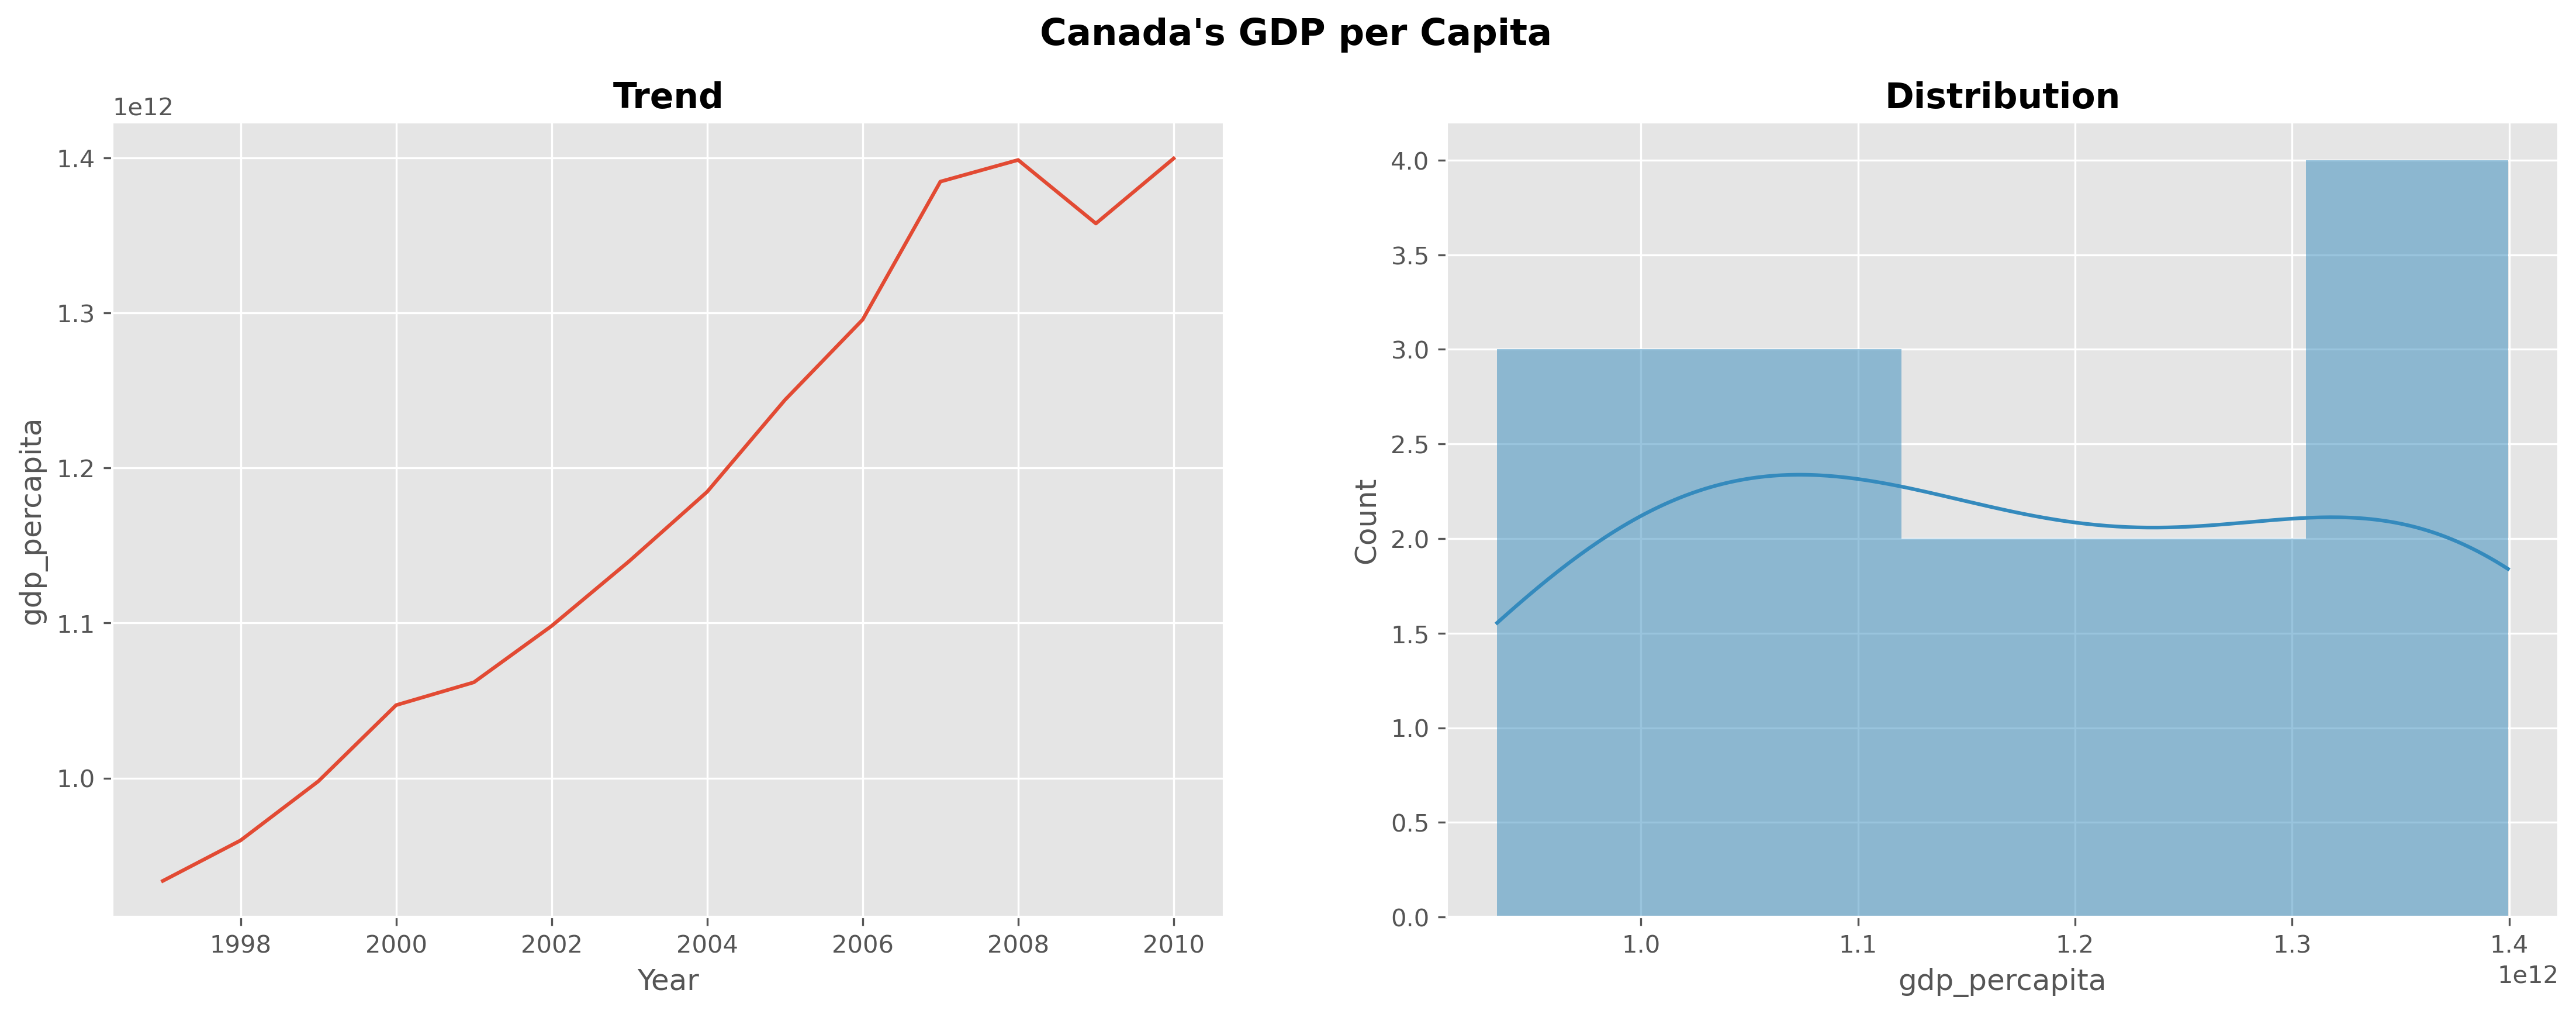

In [8]:
def plot_and_distrib(data, title, filename):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    sns.lineplot(data=data, ax=ax1)
    sns.histplot(data=data, kde=True, 
                ax=ax2, palette="Set1", linewidth=0)
    ax1.set_title("Trend")
    ax2.set_title("Distribution")
    fig.suptitle(title, fontsize=15)
    fig.savefig(os.path.join(img_path, filename))
    plt.show()
    
plot_and_distrib(g7_X_train.loc["Canada"]["gdp_percapita"], 
                 "Canada's GDP per Capita", 
                 "canada_gdp_percapita.png")

The trend of the data is upward in a linear manner. Furthermore, the distribution is obviously not symmetric, and is *akin* to a uniform distribution.

Given these, we can try to use scikit learn's `KNN Imputer.`

### Dev-7: GHG per GDP

There are only two missing values and they are the ones encoded as `false` as seen in our data wrangling phase. 

In [9]:
dev7_X_train.loc["Iran"]

,ghg_pergdp,gdp_percapita,population,fossilfuels_percapita,nuclear_percapita,renewables_percapita,yearly_oil_co2,yearly_gas_co2,yearly_flaring_co2,yearly_coal_co2,yearly_cement_co2
Year,,,,,,,,,,,
1990,1927.21,1.878936e+11,56366212.0,14595.216,0.0,363.744,139.287,40.014,21.819,2.693,6.130
1991,NaN,2.111866e+11,57679024.0,15599.069,0.0,270.029,143.967,49.617,22.314,3.843,6.270
1992,NaN,2.172315e+11,58780376.0,16653.096,0.0,434.956,142.942,52.647,21.734,3.386,6.226
1993,4708.54,2.194654e+11,59723760.0,15030.506,0.0,489.893,146.528,60.690,17.697,4.133,6.559
1994,4630.66,2.162304e+11,60590610.0,16866.006,0.0,316.145,157.266,73.287,22.314,4.173,6.780
1995,3628.79,2.211693e+11,61442656.0,17573.541,0.0,376.275,156.607,81.575,22.504,3.909,6.986
1996,3024.32,2.326637e+11,62294920.0,18750.098,0.0,393.023,158.269,81.247,23.084,4.089,7.081
1997,3349.58,2.338231e+11,63136308.0,19271.870,0.0,261.385,143.211,90.915,21.159,4.196,7.565
1998,3533.59,2.389069e+11,63971836.0,19610.201,0.0,325.143,174.869,98.652,19.236,4.884,7.862


Again, we will further examine by plotting the trend and  distribution of Iran's GHG per GDP.

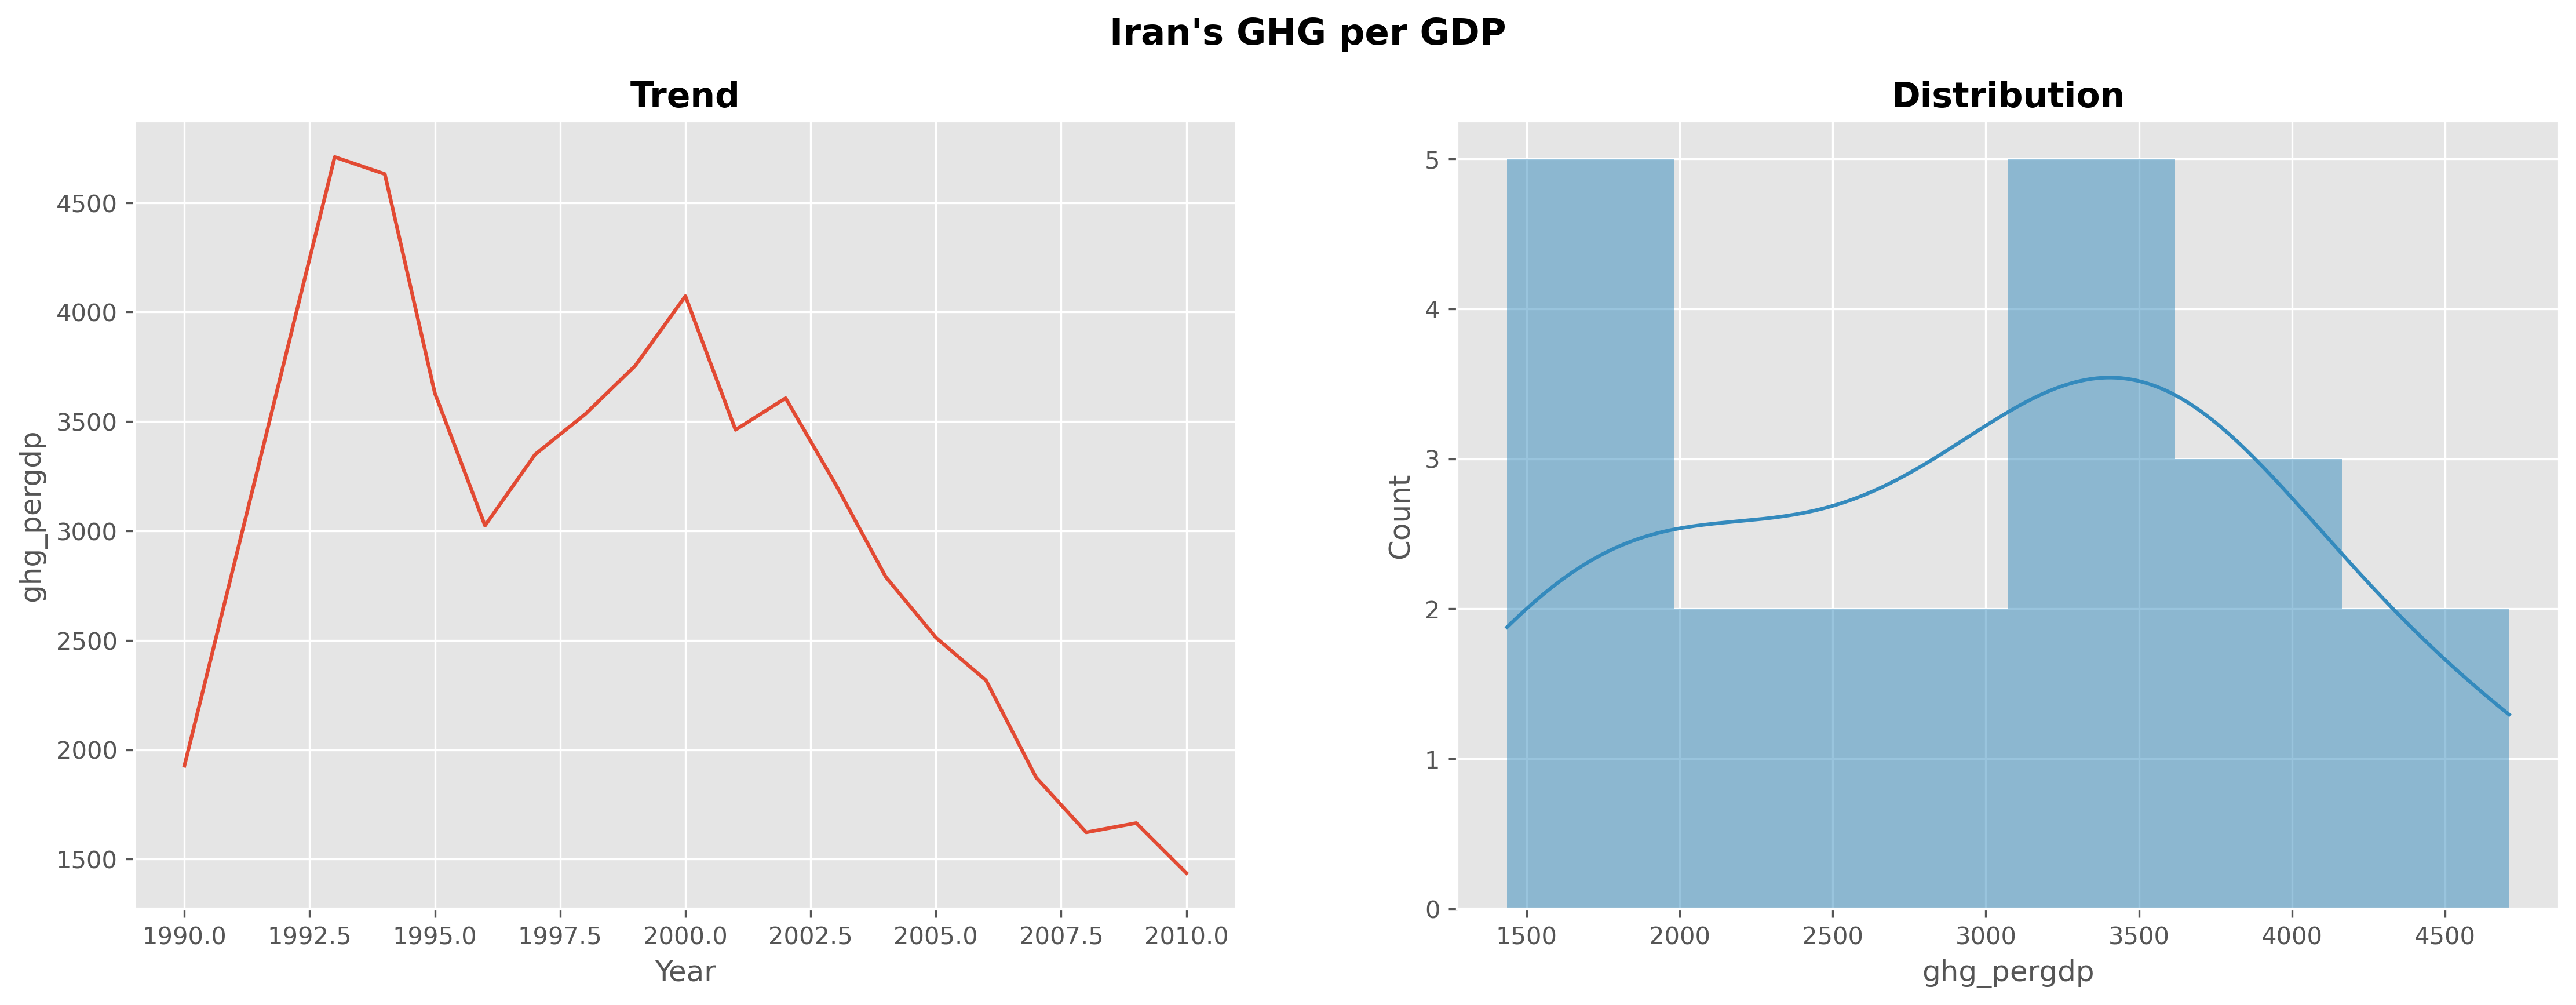

In [10]:
plot_and_distrib(dev7_X_train.loc["Iran"]["ghg_pergdp"], 
                 "Iran's GHG per GDP", 
                 "iran_ghg_pergdp.png")

Iran's GHG per GDP has no clear trend. It fluctuates unpredictably. Subsequently, its distribution is also not symmetric, similar to that of Canada's GDP per Capita.

For this, we will also be using `KNN Imputer`.

### Dev-7: Cumulative Production from Flaring

In [11]:
dev7_X_train.loc[dev7_X_train["yearly_flaring_co2"].isna()]

ghg_pergdp  gdp_percapita    population  \
Country      Year                                            
China        1990     7963.54   1.027377e+12  1.135185e+09   
             1991     7886.26   1.122541e+12  1.150780e+09   
             1992     7389.13   1.282218e+12  1.164970e+09   
             1993     7595.13   1.460237e+12  1.178440e+09   
             1994     6253.15   1.650605e+12  1.191835e+09   
             1995     5334.30   1.831412e+12  1.204855e+09   
             1996     4578.60   2.013135e+12  1.217550e+09   
             1997     4121.88   2.199084e+12  1.230075e+09   
             1998     3987.44   2.371622e+12  1.241935e+09   
             1999     3705.09   2.553328e+12  1.252735e+09   
             2000     3508.24   2.770108e+12  1.262645e+09   
             2001     3329.78   3.001017e+12  1.271850e+09   
             2002     3243.02   3.275119e+12  1.280400e+09   
             2003     3244.55   3.603876e+12  1.288400e+09   
             2004     3138.03   3.968358e+12  1.296075e+09   
             2005     3002.14   4.420537e+12  1.303720e+09   
             2006     2742.44   4.982871e+12  1.311020e+09   
             2007     2299.90   5.691977e+12  1.317885e+09   
             2008     1840.46   6.241291e+12  1.324655e+09   
             2009     1773.17   6.827893e+12  1.331260e+09   
             2010     1621.84   7.554099e+12  1.337705e+09   
South Africa 1990     2765.12   1.692312e+11  3.680051e+07   
             1991     2545.21   1.675080e+11  3.771895e+07   
             1992     2322.08   1.639283e+11  3.867261e+07   
             1993     2388.97   1.659504e+11  3.963375e+07   
             1994     2338.51   1.712608e+11  4.056406e+07   
             1995     2169.89   1.765699e+11  4.143576e+07   
             1996     2356.75   1.841624e+11  4.224101e+07   
             1997     2368.25   1.889506e+11  4.298746e+07   
             1998     2677.63   1.898953e+11  4.368226e+07   
             1999     2545.93   1.944528e+11  4.433855e+07   
             2000     2574.38   2.026199e+11  4.496771e+07   
             2001     3165.20   2.080906e+11  4.557127e+07   
             2002     3466.14   2.157907e+11  4.615091e+07   
             2003     2406.95   2.221546e+11  4.671920e+07   
             2004     1965.64   2.322727e+11  4.729161e+07   
             2005     1744.37   2.445299e+11  4.788060e+07   
             2006     1664.00   2.582328e+11  4.848946e+07   
             2007     1577.63   2.720753e+11  4.911977e+07   
             2008     1757.84   2.807574e+11  4.977947e+07   
             2009     1633.68   2.764391e+11  5.047701e+07   
             2010     1348.81   2.848421e+11  5.121697e+07   

                   fossilfuels_percapita  nuclear_percapita  \
Country      Year                                             
China        1990               6474.958              0.000   
             1991               6730.858              0.000   
             1992               7007.914              0.000   
             1993               7441.644              3.656   
             1994               7782.610             33.324   
             1995               7910.112             28.726   
             1996               8281.665             31.821   
             1997               8243.434             31.735   
             1998               8185.071             30.792   
             1999               8428.182             32.403   
             2000               8616.094             36.025   
             2001               8954.523             37.116   
             2002               9713.995             52.699   
             2003              11325.399             89.773   
             2004              13132.342            103.259   
             2005              14849.716            107.306   
             2006              16191.771            109.528   
             2007              17470.920            122.610   
             2008             

South Africa and China have no records whatsoever of cumulative flaring. In our view, this can be treated as **Missing not at Random** i.e., they have no flaring in the first place so there wouldn't be data of it.

So that we would be sure with this statement, [this data source](https://ourworldindata.org/grapher/cumulative-co2-flaring?tab=table&time=1984..latest) shows that **the last cumulative flaring data from China is from 1984**. There are no reports after. 

Subsequently, there are also **no records of cumulative flaring for South Africa**. 

This leads us to the choice of imputing these with a constant value of `0.0`.

## Imputation and Scaling

Now that we have analyzed the context of these `NaN`s for each dataset. We then programmatically define the imputation strategies for each column in each category. We also define our scaling methods here. 

**Linear Regression**, the main model family to be used for this project, is only sensitive to [scaling](https://stats.stackexchange.com/questions/29781/when-conducting-multiple-regression-when-should-you-center-your-predictor-varia) and [outliers](https://www.codecademy.com/article/normalization). Hence there will be no efforts in asserting gaussian distributions for each feature. Scaling efforts will concern itself only with centering the features towards 0 and have a unit standard deviation. For this, we will be utilizing scikit learn's `StandardScaler`. This is because using the `MinMaxScaler` does not alleviate the outliers in our data, hence we choose the former.

**Gradient boosting**, on the other hand, **has no need for scaling**. But we'll scale nonetheless to account for the linear regression model variants.

### Optimize KNN Imputer 

`KNN Imputer` has hyperparamaters `n_neighbors` and `weights`. Similar to the pre-processing in Bernardo et. al (2021), we want NOT to reject the null hypothesis $H_o$ of the Mann-Whitney U-Test. **The intuition behind this is that we want to retain, or at least emulate simularity for, the distribution of the imputed data to the original one**.

We are using the **Mann-Whitney U Test instead of the Wilcoxon signed-rank test because the data is independent and not paired**. By paired, we mean that each data point in one data set is related to one, and only one, data point in the other data set.

For the Mann-Whitney U-test, the [hypotheses](https://stats.stackexchange.com/questions/113936/what-is-the-difference-between-the-mann-whitney-and-wilcoxon-rank-sumtest) are:
<center>

$H_o$: The distributions are the same. (Choose if $p\geq0.05$) 

$H_a$: The distributions differ. (Choose if $p<0.05$)

</center>


There is **no need to maximize the p-value, so long as the null hypothesis is not rejected**. Hence, we just play around with the `weights` hyperparameter.

In [12]:
# init imputer optimizer function
def optim_knn_imputer(data, column, n_range=range(1, 2)):
    # init containers
    num_neighbors = []
    weights = []
    p_value = []
    
    # iterate through hyperparameters and store values
    for n in n_range: 
        for weight in ["uniform", "distance"]:
            
            knn_imputer = KNNImputer(n_neighbors=n, weights=weight)
            knn_imputer.fit(data)

            imputed_data = pd.DataFrame(knn_imputer.transform(data), columns=data.columns)

            _, p = mannwhitneyu(imputed_data[column], data[column].dropna())
            
            num_neighbors.append(n)
            weights.append(weight)
            p_value.append(p)
     
    # store all values and display top 3 with respect to p-value        
    result = (pd.DataFrame({"num_neighbors": num_neighbors, 
                           "weight": weights, 
                           "p": p_value})
              .sort_values(by="p", ascending=False)
              .reset_index(drop=True))       
    display(result.head(3))
    
    return result.iloc[0, :2]

In [13]:
# for G7 GDP per Capita
g7_n_neighbors, g7_weights = optim_knn_imputer(g7_X_train, "gdp_percapita")

,num_neighbors,weight,p
0,1,uniform,0.489221
1,1,distance,0.488776


In [14]:
# for Dev-7 GHG per GDP
dev7_n_neighbors, dev7_weights = optim_knn_imputer(dev7_X_train, "ghg_pergdp")

,num_neighbors,weight,p
0,1,uniform,0.932062
1,1,distance,0.932062


### Impute and Scale

In [15]:
dev7_X_train.columns

Index(['ghg_pergdp', 'gdp_percapita', 'population', 'fossilfuels_percapita',
       'nuclear_percapita', 'renewables_percapita', 'yearly_oil_co2',
       'yearly_gas_co2', 'yearly_flaring_co2', 'yearly_coal_co2',
       'yearly_cement_co2'],
      dtype='object')

In [16]:
# init column transformers
g7_col_transformers = ColumnTransformer(transformers=[
    (
        "num_impute", 
        KNNImputer(n_neighbors=g7_n_neighbors, weights=g7_weights),
        g7_X_train.columns
    )
])

dev7_col_transformers = ColumnTransformer(transformers=[
    (
        "zero_impute", 
        SimpleImputer(strategy="constant", fill_value=0),
        ["yearly_flaring_co2"]
    ),  
    (
        "num_impute", 
        KNNImputer(n_neighbors=dev7_n_neighbors, weights=dev7_weights), 
        ['ghg_pergdp', 'gdp_percapita', 'population', 'fossilfuels_percapita',
       'nuclear_percapita', 'renewables_percapita', 'yearly_oil_co2',
       'yearly_gas_co2', 'yearly_coal_co2', 'yearly_cement_co2']
    )], remainder="passthrough")

# init pipelines
g7_preprocessing_pipeline = Pipeline(steps=[
    ("impute", g7_col_transformers), 
    ("scaler", StandardScaler())
])

dev7_preprocessing_pipeline = Pipeline(steps=[
    ("impute", dev7_col_transformers), 
    ("scaler", StandardScaler())
])

# fit 
g7_preprocessing_pipeline.fit(g7_X_train)
dev7_preprocessing_pipeline.fit(dev7_X_train);

In [17]:
# overwrite
g7_X_train = pd.DataFrame(g7_preprocessing_pipeline.transform(g7_X_train),
                          columns=g7_X_train.columns, index=g7_X_train.index)
g7_X_val = pd.DataFrame(g7_preprocessing_pipeline.transform(g7_X_val),
                         columns=g7_X_val.columns, index=g7_X_val.index)
g7_X_test = pd.DataFrame(g7_preprocessing_pipeline.transform(g7_X_test),
                         columns=g7_X_test.columns, index=g7_X_test.index)

dev7_X_train = pd.DataFrame(dev7_preprocessing_pipeline.transform(dev7_X_train),
                            columns=['yearly_flaring_co2', 'ghg_pergdp', 'gdp_percapita', 'population', 
                                     'fossilfuels_percapita', 'nuclear_percapita', 'renewables_percapita', 
                                     'yearly_oil_co2', 'yearly_gas_co2', 'yearly_coal_co2', 'yearly_cement_co2'],
                            index=dev7_X_train.index)
dev7_X_val = pd.DataFrame(dev7_preprocessing_pipeline.transform(dev7_X_val),
                            columns=['yearly_flaring_co2', 'ghg_pergdp', 'gdp_percapita', 'population', 
                                     'fossilfuels_percapita', 'nuclear_percapita', 'renewables_percapita', 
                                     'yearly_oil_co2', 'yearly_gas_co2', 'yearly_coal_co2', 'yearly_cement_co2'],
                            index=dev7_X_val.index)
dev7_X_test = pd.DataFrame(dev7_preprocessing_pipeline.transform(dev7_X_test),
                            columns=['yearly_flaring_co2', 'ghg_pergdp', 'gdp_percapita', 'population', 
                                     'fossilfuels_percapita', 'nuclear_percapita', 'renewables_percapita', 
                                     'yearly_oil_co2', 'yearly_gas_co2', 'yearly_coal_co2', 'yearly_cement_co2'],
                            index=dev7_X_test.index)


In [18]:
def diagnose_nan(train, val, test):
    print(f"Train| NaN Percentage: {pd.isna(train).sum().sum()/train.shape[0]}")
    print(f"Validation| NaN Percentage: {pd.isna(val).sum().sum()/val.shape[0]}")
    print(f"Test| NaN Percentage: {pd.isna(test).sum().sum()/test.shape[0]}")

In [19]:
diagnose_nan(g7_X_train, g7_X_val, g7_X_test)

Train| NaN Percentage: 0.0
Validation| NaN Percentage: 0.0
Test| NaN Percentage: 0.0


In [20]:
diagnose_nan(dev7_X_train, dev7_X_val, dev7_X_test)

Train| NaN Percentage: 0.0
Validation| NaN Percentage: 0.0
Test| NaN Percentage: 0.0


In [21]:
# save data for modelling use
def save_data(data, filenames):
    for df, filename in zip(data, filenames):
        df.to_csv(os.path.join(data_path, filename))
        
save_data([g7_X_train, g7_X_val, g7_X_test, g7_y_train, g7_y_val, g7_y_test], 
          ["g7_X_train.csv", "g7_X_val.csv", "g7_X_test.csv", "g7_y_train.csv", "g7_y_val.csv", "g7_y_test.csv"])
        
save_data([dev7_X_train, dev7_X_val, dev7_X_test, dev7_y_train, dev7_y_val, dev7_y_test], 
          ["dev7_X_train.csv", "dev7_X_val.csv", "dev7_X_test.csv", "dev7_y_train.csv", "dev7_y_val.csv", "dev7_y_test.csv"])

## Sources

[1] Bernardo, A. B., Cordel, M. O., Lucas, R. I. G., Teves, J. M. M., Yap, S. A., & Chua, U. C. (2021). Using Machine Learning Approaches to Explore Non-Cognitive Variables Influencing Reading Proficiency in English among Filipino Learners. Education Sciences, 11(10), 628.

In [22]:
%load_ext watermark
%watermark -v -iv 

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.28.0

numpy     : 1.20.3
seaborn   : 0.11.2
sklearn   : 1.0
scipy     : 1.7.1
matplotlib: 3.4.3
sys       : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:15:42) [MSC v.1916 64 bit (AMD64)]
pandas    : 1.3.4

